# Pachyderm - Apache Spark - MLflow Integration: Provenance and Tracking for Scalable Machine Learning Training

> This project was created by [Winder.ai, an ML consultancy](https://winder.ai/), and funded by [Pachyderm](https://pachyderm.com).

[Pachyderm](https://pachyderm.com) is a data science platform that combines Data Lineage with End-to-End Pipelines.
[Apache Spark](https://spark.apache.org/) is a multi-language engine for executing data engineering, data science, and machine learning (ML) on single-node machines or clusters.
[MLflow](https://mlflow.org/) is an open source platform for managing machine learning lifecycle and tracking experiments.

This notebook shows how you can employ these platform to orchestrate a machine learning pipeline composed of an extract, transform, and load (ETL) step, and an ML training stage with comprehensive tracking of parameters, results and artifacts such as trained models.
Furthermore, it shows how Pachyderm's lineage integrates with an ML tracking server to provide artifact provenance.

The purpose of this demo is to show how Pachyderm can be used in concert with Spark and MLflow to train an ML model and track related artifacts. 
Therefore, I'll demonstrate an example of ML fraud detection based on a synthetic financial dataset with a focus on the end-to-end pipeline rather than model statistics and performance.

## Prerequiestes: 

- The [demo prerequistes](https://gitlab.com/WinderAI/pachyderm/databricks-demo/-/tree/main/minikube_install) shipped in this repository
-  A [Pachyderm client](https://docs.pachyderm.com/latest/getting_started/local_installation/#install-pachctl) (i.e. `pachctl`) installed on your local machine
- Python and Jupyter Lab to run this notebook
- `unzip` executable to unpack the raw dataset

## Check Pachyderm cluster

In [1]:
!pachctl version

COMPONENT           VERSION             
pachctl             2.0.1               
pachd               2.0.1               


## Add Raw Data

Below I create a data repository and populate it with the publicly PaySim1 financial fraud dataset available on Kaggle under a CC BY-SA 4.0 licence.
It's included in this repository so all I have to do is unpack it and a put it in Pachyderm.

In [2]:
!unzip -o raw_dataset.zip

Archive:  raw_dataset.zip
  inflating: PS_20174392719_1491204439457_log.csv  


In [3]:
!pachctl create repo raw_data

In [4]:
!pachctl put file -r raw_data@master -f PS_20174392719_1491204439457_log.csv --compress --progress=false

In [5]:
!pachctl list commit raw_data@master

REPO     BRANCH COMMIT                           FINISHED               SIZE     ORIGIN DESCRIPTION
raw_data master f18e3cb3496e4a1fa853f05cb357dc62 Less than a second ago 470.7MiB USER    


In [6]:
!pachctl list file raw_data@master

NAME                                  TYPE SIZE     
/PS_20174392719_1491204439457_log.csv file 470.7MiB 


## Data Sharding pipeline: Split Records per Customer

Designing an effective ML training pipeline likely entails turning lots of raw datapoints into a dataset that represents the business objective at stake.
In a context where each user generates a multitude of signals, it's often sensible to aggregate such information into smaller pieces.
With that in mind, I create a pipeline to split the raw data producing a chunk for each customer.
This is just a preliminary step for the following aggregation stage. 
It uses a simple python script to output a sharded data repository; to limit the computation time of this demo to a resonable amount I've added a *subsample* flag that reduces the amount of data being processed.

In [7]:
%%writefile pipeline_split_data.json
{
  "pipeline": {
    "name": "split_data"
  },
  "description": "A pipeline splits raw datasets producing a chunk per customer.",
  "transform": {
    "cmd": [
      "python",
      "/split-dataset.py",
      "/pfs/raw_data/",
      "/pfs/out/",
      "--subsample",
    ],
    "image": "winderresearch/pachyderm-split-csv:0.1.0"
  },
  "parallelism_spec": {
    "constant": 1
  },
  "input": {
    "pfs": {
      "repo": "raw_data",
      "glob": "/*"
    }
  }
}

Overwriting pipeline_split_data.json


In [8]:
!pachctl delete pipeline split_data
!pachctl create pipeline -f pipeline_split_data.json
!pachctl wait commit split_data@master --raw > /dev/null 2>&1

In [9]:
!pachctl list pipeline split_data
!echo
!pachctl list job -p split_data --no-pager

NAME       VERSION INPUT       CREATED            STATE / LAST JOB  DESCRIPTION                                                    
split_data 1       raw_data:/* About a minute ago running / success A pipeline splits raw datasets producing a chunk per customer. 

PIPELINE   ID                               STARTED        DURATION   RESTART PROGRESS  DL       UL       STATE   
split_data da4117bc7de24fbea0d13dd947e29d6e 31 seconds ago 30 seconds 0       1 + 0 / 1 470.7MiB 9.897KiB success 


In [10]:
!pachctl logs --pipeline=split_data

Processing csv dataset: /pfs/raw_data/PS_20174392719_1491204439457_log.csv
Completed in 0:00:21.772345


The resulting csv files are named after the customer id they represet.

In [11]:
!pachctl list file split_data@master | awk '{print $1}' | head -n 10

NAME
/1055929140.csv
/1083110206.csv
/1141876486.csv
/1206877978.csv
/123757418.csv
/1248586428.csv
/1282235003.csv
/1359467526.csv
/1419296243.csv


## Apache Spark ETL pipeline: Aggregate Customer Datapoints

The scenario at this point has two dimensions, one being a potentially large number of customers (i.e. many csv chunks) and the second being tons of records for each customer (i.e. large csv files).

Luckily, Pachyderm is perfectly capable of handling the former by distributing data among workers. I achieve that in the pipeline below by creating a pool of 8 workers with `parallelism_spec` (more about it in the [official docs](https://docs.pachyderm.com/latest/reference/pipeline_spec/#parallelism-spec-optional)).
Furthermore, to control how Pachyderm distributes shards across workers, I set the `input.pfs.glob` spec to `/*`, which is a specific glob pattern that exposes each csv file to a separate unit of work. 
For more details on how glob patterns work I point you to the related [docs](https://docs.pachyderm.com/latest/concepts/pipeline-concepts/datum/glob-pattern/).

The latter dimension is addressed by using Spark to process each customer data separately. 
Apache Spark is known for it's ability in dealing with potentually humongous datasets hence it's well suited for this task.
In detail, the Spark script run by this pipeline collapses a customer's data into an aggregated form by computing an average of their transactions. 

In [28]:
%%writefile pipeline_etl.json
{
  "pipeline": {
    "name": "etl"
  },
  "description": "A pipeline maps a PySpark aggregation function over dataset shards.",
  "transform": {
    "cmd": [
      "spark-submit",
      "--conf", "spark.ui.enabled=false",  
      "/root/etl.py",
      "/pfs/split_data/",
      "/pfs/out/"
    ],
    "image": "winderresearch/pachyderm-spark:0.1.0"
  },
  "parallelism_spec": {
    "constant": 8
  },
  "input": {
    "pfs": {
      "repo": "split_data",
      "glob": "/*"
    }
  }
}

Overwriting pipeline_etl.json


In [29]:
!pachctl delete pipeline etl
!pachctl create pipeline -f pipeline_etl.json
!pachctl wait commit etl@master --raw > /dev/null 2>&1

In [30]:
!pachctl list pipeline etl
!echo
!pachctl list job -p etl --no-pager

NAME VERSION INPUT         CREATED        STATE / LAST JOB  DESCRIPTION                                                         
etl  1       split_data:/* 15 minutes ago running / success A pipeline maps a PySpark aggregation function over dataset shards. 

PIPELINE ID                               STARTED       DURATION  RESTART PROGRESS    DL       UL       STATE   
etl      d8a1fcf32c5c42b5a331ce442c474533 7 minutes ago 7 minutes 0       50 + 0 / 50 9.897KiB 10.01KiB success 


In [31]:
!pachctl logs --pipeline=etl --datum=$(pachctl list datum etl@$(pachctl list job -p etl --no-pager | awk '{print $2}' | tail -n 1) | awk '{print $1}' | head -n 2 | tail -n 1) | tail -n 12

Completed in 0:00:53.582093
21/12/22 11:14:07 INFO SparkContext: Invoking stop() from shutdown hook
21/12/22 11:14:07 INFO MapOutputTrackerMasterEndpoint: MapOutputTrackerMasterEndpoint stopped!
21/12/22 11:14:07 INFO MemoryStore: MemoryStore cleared
21/12/22 11:14:07 INFO BlockManager: BlockManager stopped
21/12/22 11:14:08 INFO BlockManagerMaster: BlockManagerMaster stopped
21/12/22 11:14:08 INFO OutputCommitCoordinator$OutputCommitCoordinatorEndpoint: OutputCommitCoordinator stopped!
21/12/22 11:14:08 INFO SparkContext: Successfully stopped SparkContext
21/12/22 11:14:08 INFO ShutdownHookManager: Shutdown hook called
21/12/22 11:14:08 INFO ShutdownHookManager: Deleting directory /tmp/spark-e8e98811-3965-4b24-a9e8-7778f49c4aef
21/12/22 11:14:08 INFO ShutdownHookManager: Deleting directory /tmp/spark-ad701ade-b48c-48b8-8973-986b665eec01/pyspark-b43f4066-f39a-46b2-b7c8-2badfdc52128
21/12/22 11:14:08 INFO ShutdownHookManager: Deleting directory /tmp/spark-ad701ade-b48c-48b8-8973-986b665

This pipeline results in a set of folders each containing a csv file.

In [32]:
!pachctl list file etl@master | awk '{print $1}' | head -n 10

NAME
/1055929140/
/1083110206/
/1141876486/
/1206877978/
/123757418/
/1248586428/
/1282235003/
/1359467526/
/1419296243/


## ML Training pipeline: Fit a Fraud Detection Model with Spark-MLlib + Tracking with MLflow

Now that I've prepared my dataset it's finally time for ML to kick in.
I'm now ready to train a fraud detector, the pipeline below uses [MLlib](https://spark.apache.org/mllib/), Spark's ML library, to load the entire dataset and fit a decision tree to classify frauds.
Note that for the sake of brevity, in this demo I don't dive into model performance and tuning.


Decision tree is a simple but poweruful ML model type which supports extended explainability, which is one the reasons for its popularity in the financial sector.
A tree structure is composed by leaves representing class labels, and branches representing conjunctions of features that lead to those class labels, for further deatils check [this article](https://en.wikipedia.org/wiki/Decision_tree).

Troughout the training run, the pipeline below uses [MLflow](https://mlflow.org/) for **tracking** a number things: model hyperparameters, peformance metrics and artifacts (i.e. serialized model).
The training script uses MLflow python client to collect those items and push them to a MLflow server.
If the demo prequistes have been installed correctly, it should be running in the cluster and accessible at http://127.0.0.1:30001/.
Feel free to familiarize with its web interface but hold on until the next section for more details on what's being tracked.


### Important
Generally speaking, Spark-MLlib works fine for simple ML models and within the scope of this demo that's just enough. However, it falls short when the problem at stake requires a more complex modelling technique such as deep-learning. Fortunately, Pachyderm can run any ML framework of your preference, in fact, in the pipeline below I could have just used Tensorflow, PyTorch or Scikit-learn.

In [33]:
%%writefile ml_train.json
{
  "pipeline": {
    "name": "ml_train"
  },
  "description": "A pipeline runs Spark-MLlib to train a machine learning fraud detector over the given dataset.",
  "transform": {
    "cmd": [
      "spark-submit",
      "/root/ml-train.py",
      "/pfs/etl/",
      "/pfs/out/"
    ],
    "image": "winderresearch/pachyderm-spark:0.1.0"
  },
  "parallelism_spec": {
    "constant": 1
  },
  "input": {
    "pfs": {
      "repo": "etl",
      "glob": "/"
    }
  },
  "datum_tries": 1
}

Overwriting ml_train.json


In [34]:
!pachctl delete pipeline ml_train
!pachctl create pipeline -f ml_train.json
!pachctl wait commit ml_train@master --raw > /dev/null 2>&1

In [35]:
!pachctl list pipeline ml_train
!echo
!pachctl list job -p ml_train --no-pager

NAME     VERSION INPUT CREATED            STATE / LAST JOB  DESCRIPTION                                                                                    
ml_train 1       etl:/ About a minute ago running / success A pipeline runs Spark-MLlib to train a machine learning fraud detector over the given dataset. 

PIPELINE ID                               STARTED        DURATION   RESTART PROGRESS  DL       UL STATE   
ml_train baaaad7a5b1c4c2e8a79cbe8beaad1c2 57 seconds ago 56 seconds 0       1 + 0 / 1 10.01KiB 0B success 


In [36]:
!pachctl logs --pipeline=ml_train | tail -n 13

Completed in 0:00:52.341481
21/12/22 11:18:50 INFO SparkContext: Invoking stop() from shutdown hook
21/12/22 11:18:50 INFO SparkUI: Stopped Spark web UI at http://localhost:4040
21/12/22 11:18:50 INFO MapOutputTrackerMasterEndpoint: MapOutputTrackerMasterEndpoint stopped!
21/12/22 11:18:50 INFO MemoryStore: MemoryStore cleared
21/12/22 11:18:50 INFO BlockManager: BlockManager stopped
21/12/22 11:18:50 INFO BlockManagerMaster: BlockManagerMaster stopped
21/12/22 11:18:50 INFO OutputCommitCoordinator$OutputCommitCoordinatorEndpoint: OutputCommitCoordinator stopped!
21/12/22 11:18:50 INFO SparkContext: Successfully stopped SparkContext
21/12/22 11:18:50 INFO ShutdownHookManager: Shutdown hook called
21/12/22 11:18:50 INFO ShutdownHookManager: Deleting directory /tmp/spark-f9f5e883-3629-45b5-b704-e98cd774ee33
21/12/22 11:18:50 INFO ShutdownHookManager: Deleting directory /tmp/spark-c2adc04d-f835-44cd-b296-56883711237b
21/12/22 11:18:50 INFO ShutdownHookManager: Deleting directory /tmp/spar

In [37]:
!pachctl list file ml_train@master

NAME                              TYPE SIZE 
/53eafaf4f39b4c1485957db02b7ee5fd file 0B   


## Inspect Provenance

The ML training has completed and pushed artifacts to MLflow.
The cell below runs a helper script that shows the Pachyderm commit and related MLflow run id.
For convenince, it also prints out an URL that links directly to the MLflow interface for that run.

Let's take a moment to understand what is shown below.
To keep full provenance, the training pipeline writes the MLflow run id (i.e. `53eafaf4f39b4c1485957db02b7ee5fd`) to a file in the output repository (i.e. `/pfs/out/`).
This results in a Pachyderm commit (i.e. `baaaad7a5b1c4c2e8a79cbe8beaad1c2`) that's effectively linked to an MLflow run!


See the screenshot below, MLflow allows you to inspect parameters, metrics and navigate through the artifacts folder where the serialized model is located.


In [51]:
!chmod +x get_provenance.sh
!./get_provenance.sh

File generated by the training pipeline (represents an MLflow run id) at "ml_train@master":
NAME                              TYPE SIZE 
/53eafaf4f39b4c1485957db02b7ee5fd file 0B   

Pachyderm commit at "ml_train@master":
REPO     BRANCH COMMIT                           FINISHED       SIZE ORIGIN DESCRIPTION
ml_train master baaaad7a5b1c4c2e8a79cbe8beaad1c2 21 minutes ago 0B   AUTO    

Follow the link below to view the logged training run in MLflow:
http://127.0.0.1:30001/#/experiments/0/runs/53eafaf4f39b4c1485957db02b7ee5fd



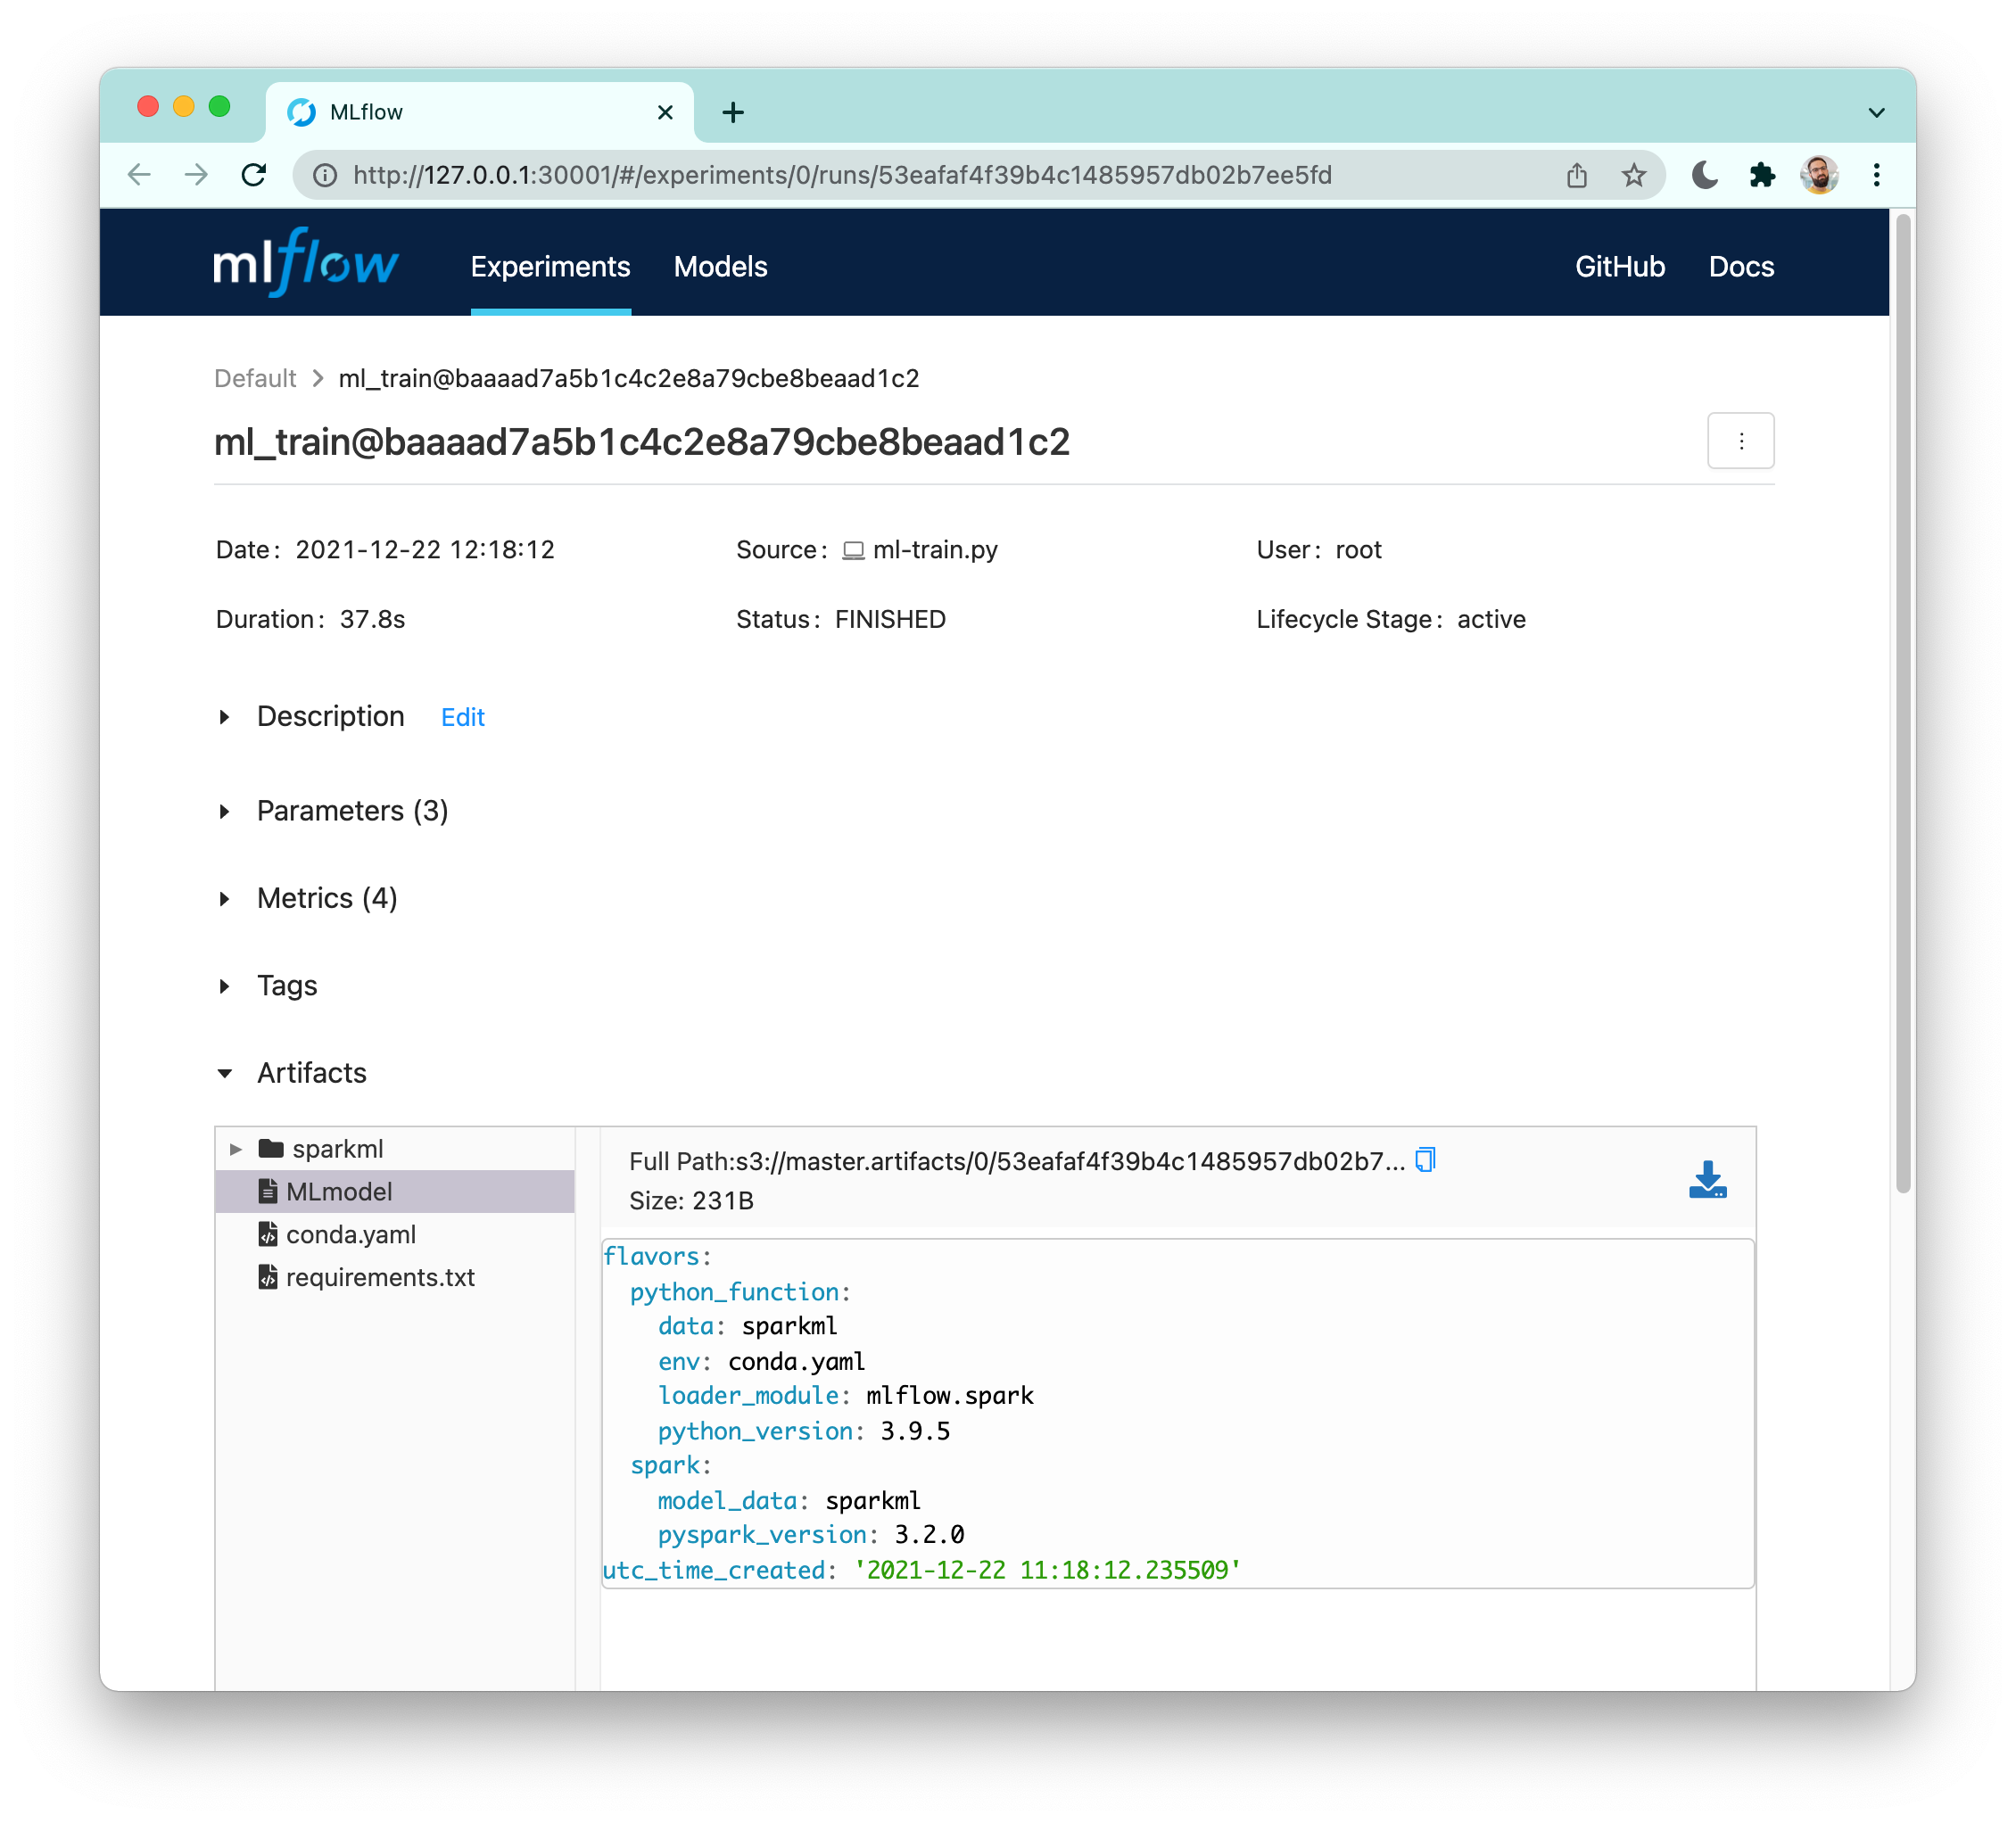

I've showcased how artifacts are linked from Pachyderm to MLflow.
Since provenance is bidirectional, let me now briefly explain how to go the other way.
Let's suppose I'm given a MLflow run id (e.g. `53eafaf4f39b4c1485957db02b7ee5fd`) and I'd like to find the corresponding Pachyderm commit.
There's a number of ways to script this, for brevity I simply list file backwards into my repository history.

In [52]:
!pachctl list file ml_train@master

NAME                              TYPE SIZE 
/53eafaf4f39b4c1485957db02b7ee5fd file 0B   


In this case, the latest commit is exactly the one that holds the run id I'm looking for.
Hence, I just fetch the related Pachyderm commit (i.e `baaaad7a5b1c4c2e8a79cbe8beaad1c2`).

In [53]:
!pachctl list commit ml_train@master

REPO     BRANCH COMMIT                           FINISHED       SIZE ORIGIN DESCRIPTION
ml_train master baaaad7a5b1c4c2e8a79cbe8beaad1c2 23 minutes ago 0B   AUTO    


## Summary

In this demo I've shown how to use Pachyderm in conjunction with Spark and MLflow to orchestrate and track a full ML training process.
Pachyderm is the backbone storage and pipelining component, it's used for artifacts lineage and to manage processing jobs.
Spark is used to pre-process a dataset as well as for training an ML model.
MLflow comes in handy to track and display a variety of aspects composing a ML training run such as parameters, metrics and artifacts such as a serialized model.